In [38]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [5]:
import os
import shutil
import random

main_folder = "D:\\leaf disease\\mango\\Dataset"
train_folder = "D:\\leaf disease\\mango\\Dataset\\training_data"
test_folder = "D:\\leaf disease\\mango\\Dataset\\testing_data"
eval_folder = "D:\\leaf disease\\mango\\Dataset\\evaluation_data"

if not os.path.exists(train_folder):
    os.makedirs(train_folder)
if not os.path.exists(test_folder):
    os.makedirs(test_folder)
if not os.path.exists(eval_folder):
    os.makedirs(eval_folder)

train_ratio = 0.75
test_ratio = 0.20
eval_ratio = 0.05

for category in os.listdir(main_folder):
    category_folder = os.path.join(main_folder, category)
    
    if os.path.isdir(category_folder):
        train_category_folder = os.path.join(train_folder, category)
        test_category_folder = os.path.join(test_folder, category)
        eval_category_folder = os.path.join(eval_folder, category)
        
        if not os.path.exists(train_category_folder):
            os.makedirs(train_category_folder)
        if not os.path.exists(test_category_folder):
            os.makedirs(test_category_folder)
        if not os.path.exists(eval_category_folder):
            os.makedirs(eval_category_folder)
        
        images = [f for f in os.listdir(category_folder) if f.endswith('.jpg')]
        
        random.shuffle(images)
        
        train_split_index = int(len(images) * train_ratio)
        test_split_index = int(len(images) * (train_ratio + test_ratio))
        
        train_images = images[:train_split_index]
        test_images = images[train_split_index:test_split_index]
        eval_images = images[test_split_index:]
        
        for img in train_images:
            src = os.path.join(category_folder, img)
            dst = os.path.join(train_category_folder, img)
            shutil.copy(src, dst)
        
        for img in test_images:
            src = os.path.join(category_folder, img)
            dst = os.path.join(test_category_folder, img)
            shutil.copy(src, dst)
        
        for img in eval_images:
            src = os.path.join(category_folder, img)
            dst = os.path.join(eval_category_folder, img)
            shutil.copy(src, dst)


In [6]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = 'D:\\leaf disease\\mango\\Dataset\\training_data',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = 'D:\\leaf disease\\mango\\Dataset\\testing_data',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)
evaluation_ds = keras.utils.image_dataset_from_directory(
    directory = 'D:\\leaf disease\\mango\\Dataset\\evaluation_data',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

Found 3000 files belonging to 11 classes.
Found 800 files belonging to 11 classes.
Found 200 files belonging to 11 classes.


In [7]:
# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)
evaluation_ds=evaluation_ds.map(process)

In [8]:
for batch in train_ds:
    images, labels = batch
    print("Batch shape:", images.shape) 
    print("Labels shape:", labels.shape)
    break 

Batch shape: (32, 256, 256, 3)
Labels shape: (32,)


In [40]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [41]:
input_shape = (32, 256, 256, 3)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [42]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (32, 60, 60, 64)        

In [44]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [45]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=validation_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


94/94 [==============================] - 13s 126ms/step - loss: nan - accuracy: 0.1257 - val_loss: nan - val_accuracy: 0.1250
Epoch 2/50
94/94 [==============================] - 11s 114ms/step - loss: nan - accuracy: 0.1250 - val_loss: nan - val_accuracy: 0.1250
Epoch 3/50
94/94 [==============================] - 11s 115ms/step - loss: nan - accuracy: 0.1250 - val_loss: nan - val_accuracy: 0.1250
Epoch 4/50
94/94 [==============================] - 11s 115ms/step - loss: nan - accuracy: 0.1250 - val_loss: nan - val_accuracy: 0.1250
Epoch 5/50
94/94 [==============================] - 11s 114ms/step - loss: nan - accuracy: 0.1250 - val_loss: nan - val_accuracy: 0.1250
Epoch 6/50
94/94 [==============================] - 11s 115ms/step - loss: nan - accuracy: 0.1250 - val_loss: nan - val_accuracy: 0.1250
Epoch 7/50
94/94 [==============================] - 11s 117ms/step - loss: nan - accuracy: 0.1250 - val_loss: nan - val_accuracy: 0.1250
Epoch 8/50
94/94 [==============================] - 

KeyboardInterrupt: 

In [28]:
model.evaluate(validation_ds)

25/25 [==============================] - 2s 51ms/step - loss: 7.9194 - accuracy: 0.5300


[7.919409275054932, 0.5299999713897705]

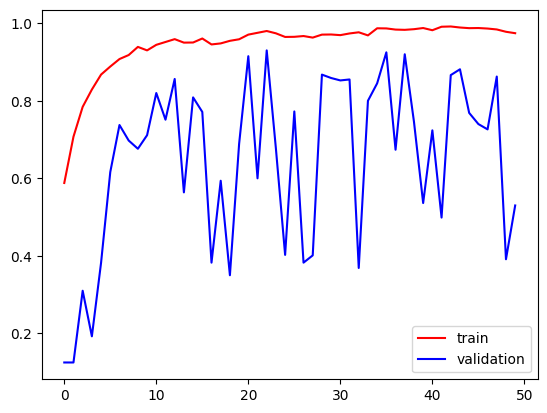

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()